# Used cars price prediction - Ironhack midterm project

## 1. EDA

In [95]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import PowerTransformer, StandardScaler, minmax_scale, OneHotEncoder
%matplotlib inline

from scipy.stats import iqr
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#### EDA results:

* 'car data.csv' has anomalies in feature values; the file is ignored in the analysis due to its low statistical value with only 300 rows.
* 'model' and 'engine' categorical columns have too many unique values; these columns will be ignored for the final data set due to the amount of dummified columns they would create after normalizing the data.
* 'seats' column has nine unique values and will be used as the closest present alternative to vehicle type.
* in order to concatenate the csv files into one dataframe columns 'location', 'color', 'mileage', 'max power', 'max torque', 'drivetrain', 'length', 'width', 'height', 'fuel tank capacity' will be ignored, since they are not present in each file.
* concatenating three csv files will result in a dataframe with roughly over 14k observations.
* no outliers require removal.

In [96]:
df1 = pd.read_csv('../data/CAR DETAILS FROM CAR DEKHO.csv')
df2 = pd.read_csv('../data/Car details v3.csv')
df3 = pd.read_csv('../data/car details v4.csv')

In [97]:
#df3.iloc[df3['Price'].idxmax()]  # <--- shows that the outliers should not be removed

In [98]:
df3.describe().round()

,Price,Year,Kilometer,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
count,2059.0,2059.0,2059.0,1995.0,1995.0,1995.0,1995.0,1946.0
mean,1702992.0,2016.0,54225.0,4281.0,1768.0,1592.0,5.0,52.0
std,2419881.0,3.0,57362.0,442.0,135.0,136.0,1.0,15.0
min,49000.0,1988.0,0.0,3099.0,1475.0,1165.0,2.0,15.0
25%,484999.0,2014.0,29000.0,3985.0,1695.0,1485.0,5.0,41.0
50%,825000.0,2017.0,50000.0,4370.0,1770.0,1545.0,5.0,50.0
75%,1925000.0,2019.0,72000.0,4629.0,1832.0,1675.0,5.0,60.0
max,35000000.0,2022.0,2000000.0,5569.0,2220.0,1995.0,8.0,105.0


## 2. Data cleaning

#### data cleaning results:
* extracted the first word (Make) in the 'name' and 'owner' columns.
* dropped extra columns.
* formatted 'selling price' column.
* concatenated three files into a new dataframe.
* checked for null values (there aren't any).
* checked for duplicates (2.2k duplicated found) and droppped them.
* check data types (all correct).

In [99]:
df1['name'] = df1['name'].apply(lambda x: x.split()[0])
df2['name'] = df2['name'].apply(lambda x: x.split()[0])


In [100]:
df1['owner'] = df1['owner'].apply(lambda x: x.split()[0])
df2['owner'] = df2['owner'].apply(lambda x: x.split()[0])

In [101]:
df3.rename(columns=
           {"Year": "year",
            "Price": "selling_price",
            "Kilometer": "km_driven", 
            "Fuel Type": "fuel", 
            "Seller Type": "seller_type", 
            "Transmission": "transmission", 
            "Make": "name",
            "Owner": "owner"},inplace=True)

df1["selling_price"] /= 100
df1["selling_price"] = df1["selling_price"].astype(int)

df2["selling_price"] /= 100
df2["selling_price"] = df2["selling_price"].astype(int)

df3["selling_price"] /= 100
df3["selling_price"] = df3["selling_price"].astype(int)

In [102]:
df2.drop(['mileage', 'engine', 'max_power', 'torque', 'seats'], axis=1, inplace=True)
df3.drop(['Model', 'Location', 'Color', 'Engine', 'Max Power', 'Max Torque', 
          'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity'], axis=1, inplace=True)


In [103]:
df = pd.concat([df1, df2, df3], ignore_index=True)

In [104]:
#check for duplicates
dup = df[df.duplicated(keep=False)].sort_values(by=['selling_price'])

In [105]:
#drop duplicates
df.drop_duplicates(inplace=True, ignore_index=True)

In [106]:
#change 'year' to 'age' (and count it)
df.rename(columns={'year': 'age'}, inplace=True)
df['age'] = df['age'].apply(lambda x: df['age'].max()+1-x)

In [107]:
#clean values in 'fuel' column
def clean_fuel(value):
    if 'CNG' in value:
        value = 'CNG'
    elif 'Petrol' in value:
        value = 'Petrol'
    return value

df['fuel'] = df['fuel'].apply(lambda x: clean_fuel(x))

In [108]:
#transform values in 'owner' column
def clean_owner(value):
    if value == 'Test' or value == 'UnRegistered Car':
        value = 0
    elif value == 'First':
        value = 1
    elif value == 'Second':
        value = 2
    elif value == 'Third':
        value = 3
    elif value == 'Fourth':
        value = 4
    elif value == '4 or More':
        value = 5
    return value

df['owner'] = df['owner'].apply(lambda x: clean_owner(x))

In [109]:
#clean 'seller_type' column
def clean_seller(value):
    if 'Dealer' in value:
        value = 'Dealer'
    elif value == 'Commercial Registration':
        value = 'Corporate'
    return value

df['seller_type'] = df['seller_type'].apply(lambda x: clean_seller(x))

In [110]:
df

,name,age,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti,16,600,70000,Petrol,Individual,Manual,1
1,Maruti,16,1350,50000,Petrol,Individual,Manual,1
2,Hyundai,11,6000,100000,Diesel,Individual,Manual,1
3,Datsun,6,2500,46000,Petrol,Individual,Manual,1
4,Honda,9,4500,141000,Diesel,Individual,Manual,2
...,...,...,...,...,...,...,...,...
12313,Mahindra,7,8500,90300,Diesel,Individual,Manual,1
12314,Hyundai,9,2750,83000,Petrol,Individual,Manual,2
12315,Ford,10,2400,73000,Petrol,Individual,Manual,1
12316,BMW,5,42900,60474,Diesel,Individual,Automatic,1


## Data transformation

#### Results:
* Made plots for km driven, year & selling price.

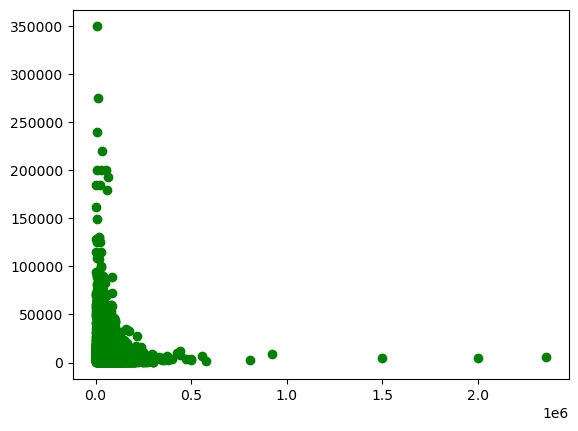

In [111]:
plt.scatter(x=df['km_driven'], y=df['selling_price'],c='g')
plt.show()

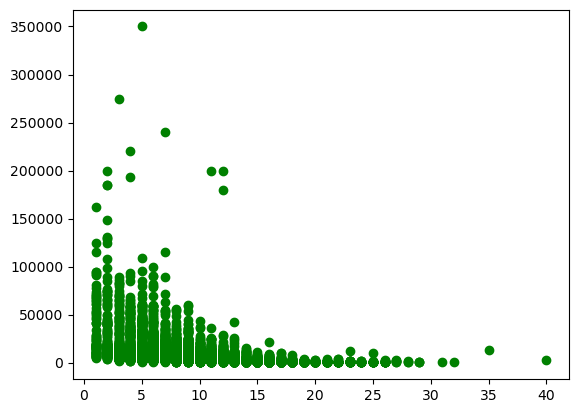

In [112]:
plt.scatter(x=df['age'], y=df['selling_price'],c='g')
plt.show()

#### removing outliers

In [113]:
#remove outliers
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]
    return df

In [114]:
numerical = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(include=[object])

In [115]:
numerical = remove_outliers(numerical)

In [116]:
df = pd.concat([numerical, categorical], axis=1)

In [117]:
df.dropna(inplace=True)

#### X, y & train, test split

In [118]:
df.isna().any().any()

False

In [119]:
X = df.drop('selling_price', axis=1)
y = df[['selling_price']].copy()

In [120]:
numericalX = X.select_dtypes(include=[np.number])
categoricalX = X.select_dtypes(include=[object])

numericalX_columns = numericalX.columns

In [121]:
scaler = StandardScaler()
scaler.fit(numericalX)
numericalX = scaler.transform(numericalX)

pt = PowerTransformer()
pt.fit(numericalX)
numericalX = pt.transform(numericalX)

numericalX = pd.DataFrame(numericalX, columns=numericalX_columns)
categoricalX = pd.get_dummies(categoricalX)


In [122]:
#concat
#X = pd.concat([pd.get_dummies(X[categoricalX.columns],drop_first=True), numericalX], axis=1)
X = pd.concat([categoricalX, numericalX], axis=1, ignore_index=True)

In [124]:
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.648339,0.225841,-0.674493
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.648339,-0.350178,-0.674493
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.603620,0.961198,-0.674493
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.864591,-0.474421,-0.674493
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.087999,1.829195,1.192254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.834386,-0.633427,1.192254
10470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087999,-0.698131,1.192254
10475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.206653,-0.380983,-0.674493
10482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087999,0.559208,1.192254


In [ ]:
tt_ratio = 0.3
rand_seed = 40

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tt_ratio, random_state=rand_seed)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
X_train_const = sm.add_constant(X_train.to_numpy()) # adding a constant
X_test_const = sm.add_constant(X_test) # adding a constant

model = sm.OLS(y_train, X_train_const).fit()

print_model = model.summary()
print(print_model)

In [ ]:
model = LinearRegression()    # model
model.fit(X_train, y_train)   # model train

In [ ]:
y_pred = pd.DataFrame(model.predict(X_test),columns = ['selling_price'] )      # model prediction

In [ ]:
yp = y_pred.to_numpy()
yt = y_test.to_numpy()

plot = sns.regplot(x=yp,y=yt,scatter_kws={"color": "red"}, line_kws={"color": "black"})
plot.set(xlabel='predicted', ylabel='test')